####  FULL RANK SECOND ORDER ELLIPTIC BVP 2D
Let $\Omega = (-1 , 1)^2$, $A=A(x, y), b=b(x, y), c=c(x, y), f \in L^2(\Omega)$ and $g\in H^{1/2}(\partial\Omega)$:

$$
    \begin{cases}
        \begin{array}{rl}
            \nabla(A\nabla u) + b \cdot \nabla u + c u + f &= 0 \text{ in } \Omega\\
            u &= g \text{ on } \partial \Omega
        \end{array}
    \end{cases}
$$

#### PDE DATA
Let $\omega > 0$ and $\lambda = 2 \pi \omega$:

$$
    \begin{split}
        g &= cos(\lambda x) sin(\lambda y)\\
        \partial_x g &= - \lambda \sin(\lambda x) \sin(\lambda y)\\
        \partial_y g &= \lambda \cos(\lambda x) \cos(\lambda y)\\
        \partial_{xy} g &= - \lambda^2 \cos(\lambda x) \cos(\lambda y)\\
        \partial_{xx} g &= - \lambda^2 \cos(\lambda x) \sin(\lambda y)\\
        \partial_{yy} g &= \partial_{xx} g
    \end{split}
$$


$$
    A \nabla  = \begin{pmatrix} 
            a_{00} \partial_x + a_{01} \partial_y \\
            a_{10} \partial_x + a_{11} \partial_y 
        \end{pmatrix}
$$


$$
    \begin{split}
        \nabla \cdot( A \nabla g) &= \partial_x(a_{00} \partial_x g + a_{01} \partial_y g) + \partial_y(a_{10} \partial_x g + a_{11} \partial_y g)\\
        &= a_{00}\partial_{xx}g + a_{11}\partial_{yy}g + (a_{01}+a_{10})\partial_{xy} g + (\partial_x a_{00} + \partial_y a_{10}) \partial_x g + (\partial_x a_{01} + \partial_y a_{11}) \partial_y g
    \end{split}
$$


$$
    - f = a_{00}\partial_{xx}g + a_{11}\partial_{yy}g + (a_{01}+a_{10})\partial_{xy} g + (\partial_x a_{00} + \partial_y a_{10} + b_0) \partial_x g + (\partial_x a_{01} + \partial_y a_{11} + b_1) \partial_y g + c g
$$

#### EXPERIMENTS
Experiment 1: $\lambda = 2 \pi \omega$, $\omega=3$, $p=\infty$;

Experiment 2: $\lambda = 2 \pi \omega$, $\omega=3$, $p=2$;

In [1]:
import numpy as np
import sys
import json
sys.path.insert(1, 'C:/Users/philh/Notebooks/thesis_framework/')
from differentiation import Differentiation
from cubature import Cubature
from benchmark import Benchmark
from utilities import matmul, data_axes, leg_bary, laplacian, inverse_lu, mui_lp_ext, cart
prefix = None #"full_rank_second_order_bvp_2d"

#### CUBATURE AND DIFFERENTIATION

In [2]:
# DOMAIN #
deg_d = [20]*2
cuba_d = Cubature(deg_d, points="Legendre") # for Lobatto points choose points="Lobatto"
w_d = cuba_d.leja_weights
xs_d = cuba_d.leja_axes
xs_plt_d = cuba_d.axes
bary = cuba_d.leja_axes_bary
diff = Differentiation(xs_d, bary)
dx, dy = diff.nabla
dx2, dxdy, dy2 = diff.diffs(np.array([[2,0],[1,1],[0,2]]))

# BOUNDARY #
deg_b = [100]
cuba_b = Cubature(deg_b)
w_b = cuba_b.leja_weights
xs_b = cuba_b.leja_axes
xs_plt_b = cuba_b.axes

#### LAPLACIAN OPERATORS

In [3]:
I = np.eye(len(w_d))
n_d = np.max(deg_d)

W_d = np.diag(w_d)
W_d_inv = np.linalg.inv(W_d)

M_1, M_1_inv = laplacian([dx, dy], [W_d_inv]*2 , [W_d]*2)
M_1_s, _ = laplacian([dx, dy], [W_d_inv]*2, [W_d]*2, weak=True)

M_1_mod = (M_1 + I/n_d**2)
M_1_s_mod = n_d*M_1_s

W_b = np.diag(w_b)

In [4]:
# ABSOLUTE ERROR OF OPERATOR NORM #
print(abs(np.linalg.norm(M_1)-1.0))
print(abs(np.linalg.norm(M_1_s)-1.0))

0.31452544140417626
0.19633107365461933


#### PDE DATA

In [5]:
a00 = lambda x, y: (1+np.sin(x)**2+np.cos(y)**2)*np.ones_like(x)*np.ones_like(y)
a01 = lambda x, y: 0*np.ones_like(x)*np.ones_like(y)
a10 = lambda x, y: 0*np.ones_like(x)*np.ones_like(y)
a11 = lambda x, y: (1+np.sin(y)**2+np.cos(x)**2)*np.ones_like(x)*np.ones_like(y)
b0 = lambda x, y: x*np.ones_like(x)*np.ones_like(y)
b1 = lambda x, y: y*np.ones_like(x)*np.ones_like(y)
c = lambda x, y: np.arctan(x+y)*np.ones_like(x)*np.ones_like(y)

a00_x = lambda x, y: 2*np.sin(x)*np.cos(x)*np.ones_like(x)*np.ones_like(y)
a01_x = lambda x, y: 0*np.ones_like(x)*np.ones_like(y)
a10_y = lambda x, y: 0*np.ones_like(x)*np.ones_like(y)
a11_y = lambda x, y: 2*np.sin(y)*np.cos(y)*np.ones_like(x)*np.ones_like(y)

omega = 0.5
lam = 2*np.pi*omega
gt = lambda x, y: np.cos(lam*x)*np.sin(lam*y)
g_x = lambda x, y: -lam*np.sin(lam*x)*np.sin(lam*y)
g_y = lambda x, y: lam*np.cos(lam*x)*np.cos(lam*y)
g_xy = lambda x, y: -lam**2*np.sin(lam*x)*np.cos(lam*y)
g_xx = lambda x, y: -lam**2*np.cos(lam*x)*np.sin(lam*y)
g_yy = g_xx

def f(x,y):
    return  - a00(x, y)*g_xx(x,y) - a11(x, y)*g_yy(x,y)\
            - (a01(x, y) + a10(x, y))*g_xy(x, y)\
            - (a00_x(x, y) + a10_y(x, y) + b0(x, y))*g_x(x, y)\
            - (a01_x(x, y) + a11_y(x, y) + b1(x, y))*g_y(x, y)\
            - c(x, y)*gt(x, y)

#### $l^p$ DEGREE AND BENCHMARK INITIALIZATION

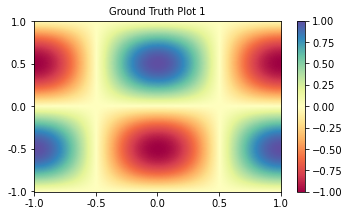

L^2 norm: 0.49999596779071215
L^inf norm: 1.0


In [6]:
# l^p #
p = np.inf
mui = mui_lp_ext(deg_d, p)

# BENCHMARK #
test_xs = [np.linspace(-1.0, 1.0, 249)]*2
data = data_axes(test_xs, mui).T
bm = Benchmark(gt, test_xs, data)
eval_gt = bm.eval_gt()
bm.plot_gt(prefix=prefix)
print(f'L^2 norm: {np.mean(np.array(eval_gt)**2)**0.5}')
print(f'L^inf norm: {np.max(abs(np.array(eval_gt)))}')

#### PDE DATA RESOLUTION

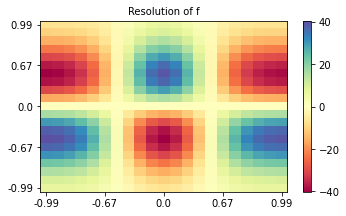

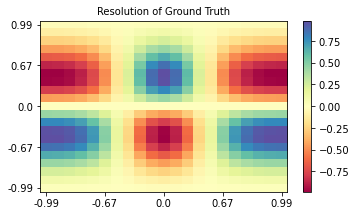

In [7]:
x_plt = cuba_d.grid[:,0]
y_plt = cuba_d.grid[:,1]
shape_plt = [len(xs_plt_d[1]), len(xs_plt_d[0])]

f_plt = f (x_plt, y_plt).reshape(*shape_plt)
gt_plt = gt(x_plt, y_plt).reshape(*shape_plt)

f_fn = None#f'{prefix}_pde_data_res_f'
gt_fn = None#f'{prefix}_pde_data_res_gt'

bm.plot2d(f_plt, xs_plt_d[0], xs_plt_d[1], title="Resolution of f", file_name=f_fn)
bm.plot2d(gt_plt, xs_plt_d[0], xs_plt_d[1], title="Resolution of Ground Truth", file_name=gt_fn)

#### REGRESSION UTILITIES

In [8]:
grid_d = cuba_d.leja_grid
crnrs = np.array([-1.0, 1.0])

C_d = data_axes(xs_d, mui).T
C_b = np.concatenate((
    data_axes([xs_b[0], crnrs], mui).T,
    data_axes([crnrs, xs_b[0]], mui).T
))

grid_b0 = cart([xs_b[0], crnrs])
grid_b1 = cart([crnrs, xs_b[0]])

gt_b = np.concatenate((
    gt(grid_b0[:,0], grid_b0[:,1]),
    gt(grid_b1[:,0], grid_b1[:,1])
))

fXY = f(grid_d[:,0], grid_d[:,1])

#### DUAL LSQ FORMULATION

In [9]:
def metric(m): return lambda x: matmul(m,x)*x
x = grid_d[:,0]
y = grid_d[:,1]

T = matmul(np.diag(a00(x,y)), dx2)+\
    matmul(np.diag(a11(x,y)), dy2)+\
    matmul(np.diag(a01(x,y)+a10(x,y)), dxdy)+\
    matmul(np.diag(a00_x(x,y)+a10_y(x,y)+b0(x,y)), dx)+\
    matmul(np.diag(a01_x(x,y)+a11_y(x,y)+b1(x,y)), dy)+\
    np.diag(c(x,y))
L = lambda u_d, u_b, metric, lam=1.0:\
    sum(w_d*metric(matmul(T, u_d)+fXY))+lam*sum(matmul(W_b,(u_b-gt_b)**2))

#### TRUNCATION ERROR

In [10]:
args = [gt(x, y), gt_b]
trunc_err = {
    "L_l2"   : L(*args, metric(I)),
    "L_"     : L(*args, metric(M_1), 1),
    "L_s"    : L(*args, metric(M_1_s), 1),
    "L_mod"  : L(*args, metric(M_1_mod), n_d),
    "L_s_mod": L(*args, metric(M_1_s_mod), n_d)}
print(f'Truncation Errors:\n{json.dumps(trunc_err, indent=5)}')

Truncation Errors:
{
     "L_l2": 8.513969333873624e-22,
     "L_": 5.473971745253908e-24,
     "L_s": 8.041031857702043e-26,
     "L_mod": 7.602464078722313e-24,
     "L_s_mod": 1.6082063715404103e-24
}


#### SOLUTION

In [11]:
def solution(m1, m2, lam=1.0):
    E = matmul(C_d.T, W_d, m2, C_d)
    TC_d = matmul(T, C_d)
    TC_d_s = matmul(E, TC_d.T, W_d, m1)
    C_b_s = matmul(E, matmul(lam*W_b, C_b).T)
    T_sT_inv = inverse_lu(matmul(TC_d_s, TC_d)+matmul(C_b_s, C_b))
    T_sf = matmul(TC_d_s, -fXY)+matmul(C_b_s, gt_b)
    theta = matmul(T_sT_inv, T_sf)
    theta = theta.reshape(len(theta),-1)
    return lambda X: np.matmul(np.array(X), theta)

In [12]:
cheb_l2 = solution(I, I)

cheb_ = solution(M_1, M_1_inv, lam=1.0)
cheb_s = solution(M_1_s, M_1_inv, lam=1.0)

cheb_mod = solution(M_1_mod, M_1_inv, lam=n_d)
cheb_s_mod = solution(M_1_s_mod, M_1_inv, lam=n_d)

# SET MODELS #
bm.set_model([cheb_l2, cheb_, cheb_s, cheb_mod, cheb_s_mod])

####  MODEL EVALUATION AND PLOT

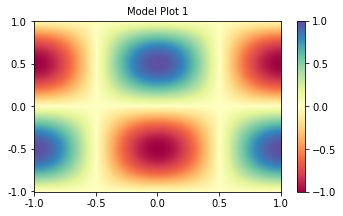

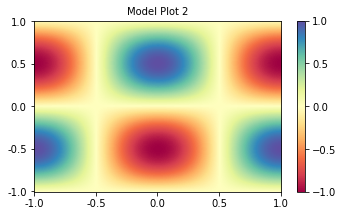

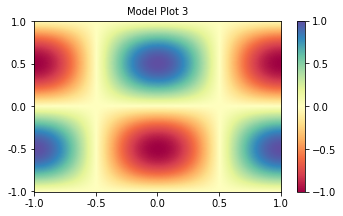

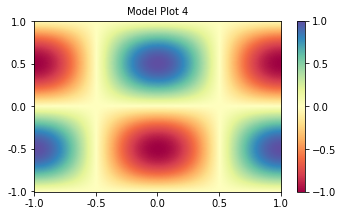

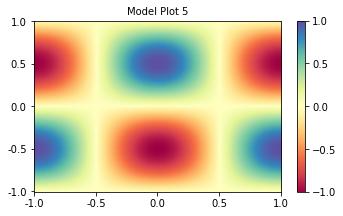

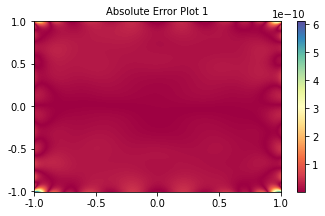

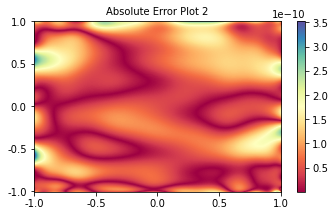

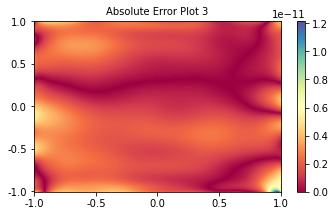

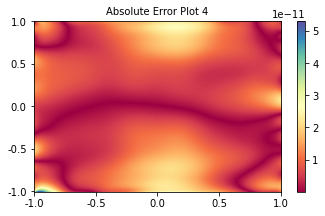

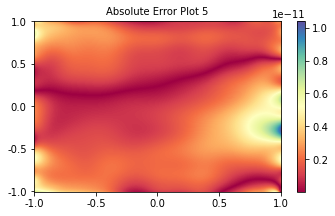

In [13]:
_ = bm.eval_model()
bm.plot_model(prefix=prefix)
bm.plot_abs_err(prefix=prefix)

#### ERROR

In [14]:
print(f'L1  Error: \n {bm.lp_err(1, precision=3)}')
print(f'L2  Error: \n {bm.lp_err(2, precision=3)}')
print(f'Max Error: \n {bm.lp_err(np.inf, precision=3)}')

L1  Error: 
 ['1.758e-11', '6.451e-11', '1.559e-12', '8.012e-12', '1.859e-12']
L2  Error: 
 ['2.649e-11', '8.204e-11', '1.854e-12', '9.832e-12', '2.229e-12']
Max Error: 
 ['6.137e-10', '3.538e-10', '1.219e-11', '5.316e-11', '1.043e-11']


#### TABLE FORMAT ERROR

In [15]:
err=np.array(
    [bm.lp_err(2, precision=2),
     bm.lp_err(np.inf, precision=2)])

row = f'{deg_d[0]} '
for _ in err.T:
    row = row + f'& {_[0]} & {_[1]} '
row = row + f'\\\\'

print(row)

20 & 2.65e-11 & 6.14e-10 & 8.20e-11 & 3.54e-10 & 1.85e-12 & 1.22e-11 & 9.83e-12 & 5.32e-11 & 2.23e-12 & 1.04e-11 \\
